In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from config import get_pdb_directories, ensure_directories_exist

# Load ASH Data
paths = get_pdb_directories()
ensure_directories_exist(paths)

data_file=paths['historical_data_file']
df = pd.read_csv(f"{data_file}.gz", compression='gzip')
df['sample_time'] = pd.to_datetime(df['sample_time'])

# Convert column names to lowercase
df.columns = df.columns.str.lower()


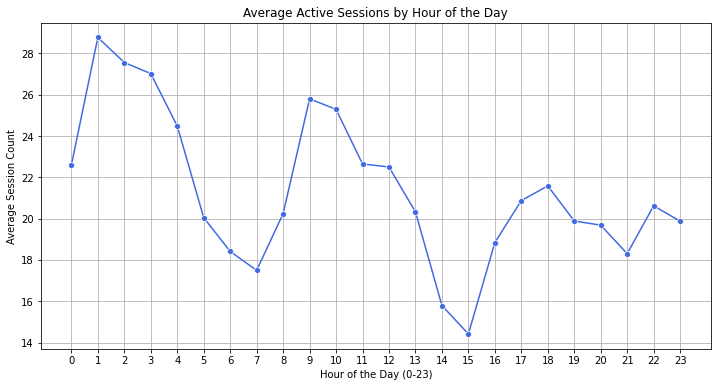

In [18]:
# Extract hour (0-23) from timestamp
df['date'] = df['sample_time'].dt.date
df['hour'] = df['sample_time'].dt.hour

# Convert session_count to AAS (Average Active Sessions) using 10-second ASH intervals.
df['aas'] = df['session_count'] / 360  # 360 samples per hour if sampled every 10 seconds


sample_metrics = df.groupby(['date', 'hour', 'sample_time']).agg({
        'session_count': 'sum',  # Total sessions at this sample point
        'instance_number': 'nunique'  # Number of instances
    }).reset_index()

#print(sample_metrics)

# Now group by date and hour to get hourly statistics
hourly_metrics = sample_metrics.groupby(['date', 'hour']).agg({
    'session_count': 'mean',  # Average sessions across all sample points in the hour
    'instance_number': 'nunique',  # Number of instances
}).reset_index()

#print(hourly_metrics)

# The session_count is now our AAS
hourly_metrics['aas'] = hourly_metrics['session_count']

#print(hourly_metrics)


# Plot Average Active Sessions by Hour of the Day
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_metrics, x='hour', y='session_count', marker='o', linestyle='-', color='royalblue', ci=None)

plt.title('Average Active Sessions by Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Session Count')
plt.xticks(range(0, 24))  # Ensure x-axis shows all 24 hours

plt.grid()
plt.show()


#test = df.groupby(['date', 'hour']).agg({
#        'aas': 'sum',  # Total sessions at this sample point
#        'instance_number': 'nunique'  # Number of instances
#    }).reset_index()
#
## Plot Average Active Sessions by Hour of the Day
#plt.figure(figsize=(12, 6))
#sns.lineplot(data=test, x='hour', y='aas', marker='o', linestyle='-', color='royalblue', ci=None)
#
#plt.title('Average Active Sessions by Hour of the Day')
#plt.xlabel('Hour of the Day (0-23)')
#plt.ylabel('Average Session Count')
#plt.xticks(range(0, 24))  # Ensure x-axis shows all 24 hours
#
#plt.grid()
#plt.show()

               date  hour             sample_time wait_class  session_count  \
0        2025-01-12    18 2025-01-12 18:08:54.750      Other              2   
1        2025-01-12    18 2025-01-12 18:08:56.928    Cluster              4   
2        2025-01-12    18 2025-01-12 18:08:56.928   User I/O              2   
3        2025-01-12    18 2025-01-12 18:08:58.118   User I/O              4   
4        2025-01-12    18 2025-01-12 18:09:06.941    Cluster              2   
...             ...   ...                     ...        ...            ...   
1654586  2025-02-11    18 2025-02-11 18:05:03.470      Other              1   
1654587  2025-02-11    18 2025-02-11 18:05:05.551    Cluster             12   
1654588  2025-02-11    18 2025-02-11 18:05:07.252    Cluster             12   
1654589  2025-02-11    18 2025-02-11 18:05:07.252     Commit              2   
1654590  2025-02-11    18 2025-02-11 18:05:07.252   User I/O              2   

         instance_number  
0                      1

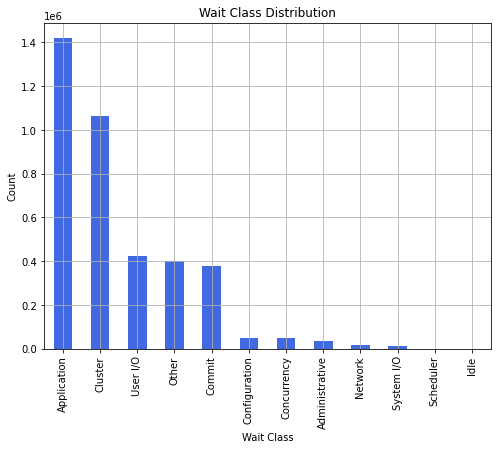

In [3]:
# Extract hour (0-23) from timestamp
df['date'] = df['sample_time'].dt.date
df['hour'] = df['sample_time'].dt.hour


# First group by sample_time and wait_class to get point-in-time totals
sample_wait_totals = df.groupby(['sample_time', 'wait_class'])['session_count'].sum().reset_index()


sample_wait_totals = df.groupby(['date', 'hour', 'sample_time', 'wait_class']).agg({
        'session_count': 'sum',  
        'instance_number': 'nunique' 
    }).reset_index()

print(sample_wait_totals)

wait_class_avg = sample_wait_totals.groupby('wait_class').agg({
    'session_count': 'mean',  
    'instance_number': 'nunique'
}).reset_index()

print(wait_class_avg)

# 1. Wait Class Distribution
plt.figure(figsize=(8, 6))
df['wait_class'].value_counts().plot(kind='bar', color='royalblue')
plt.title('Wait Class Distribution')
plt.xlabel('Wait Class')
plt.ylabel('Count')
plt.grid()
plt.show()


,date,hour,wait_class,aas,instance_number
0,2025-01-12,18,Administrative,0.005556,1
1,2025-01-12,18,Application,0.144444,3
2,2025-01-12,18,Cluster,2.272222,3
3,2025-01-12,18,Commit,1.716667,3
4,2025-01-12,18,Concurrency,0.044444,3
...,...,...,...,...,...
6731,2025-02-11,18,Concurrency,0.005556,1
6732,2025-02-11,18,Configuration,0.019444,3
6733,2025-02-11,18,Other,0.255556,3
6734,2025-02-11,18,System I/O,0.005556,1


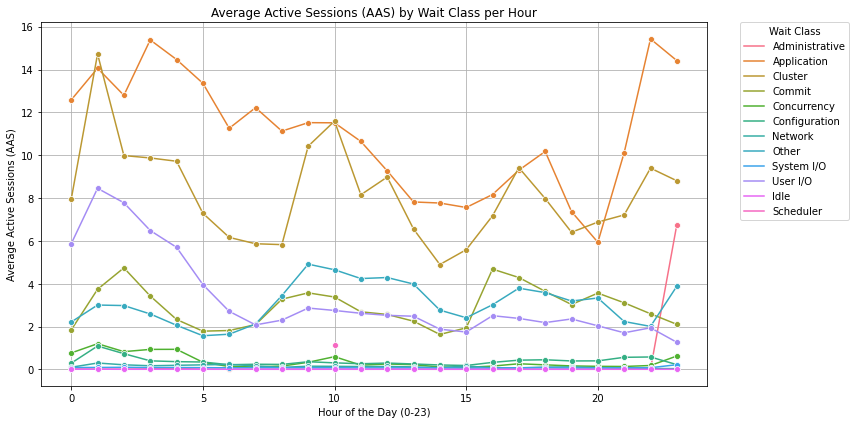

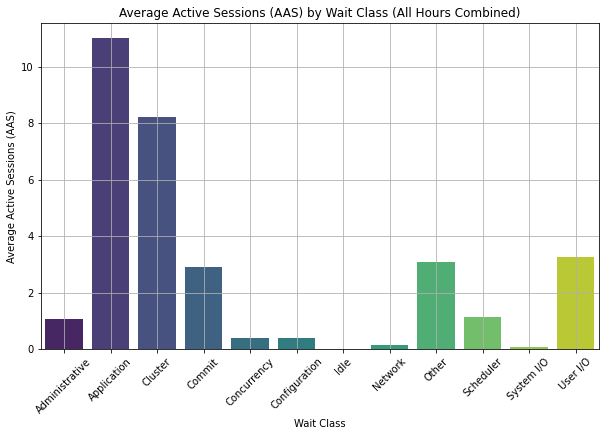

In [19]:
# 1. Extract date and hour from timestamp
df['date'] = df['sample_time'].dt.date
df['hour'] = df['sample_time'].dt.hour

# 2. Normalize AAS Calculation for Accurate Results
# Convert session_count to AAS (Average Active Sessions) using 10-second ASH intervals.
df['aas'] = df['session_count'] / 360  # 360 samples per hour if sampled every 10 seconds


# 3. Aggregate AAS by Hour and Wait Class (for hourly trends)
sample_wait_totals = df.groupby(['date','hour', 'wait_class']).agg({
    'aas': 'sum',  # Use mean to get the average AAS per hour per wait class
    'instance_number': 'nunique'  # Number of unique instances
}).reset_index()

display(sample_wait_totals)

# 4. Line Plot: Hourly AAS by Wait Class
plt.figure(figsize=(12, 6))
sns.lineplot(data=sample_wait_totals, x='hour', y='aas', hue='wait_class', marker='o', ci=None)
plt.title('Average Active Sessions (AAS) by Wait Class per Hour')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Active Sessions (AAS)')
plt.grid()
plt.legend(title='Wait Class', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)  # Legend outside
plt.tight_layout()
plt.show()

# 5. Bar Plot: Average AAS by Wait Class Across All Hours
wait_class_avg = sample_wait_totals.groupby('wait_class')['aas'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=wait_class_avg, x='wait_class', y='aas', palette='viridis')
plt.title('Average Active Sessions (AAS) by Wait Class (All Hours Combined)')
plt.xlabel('Wait Class')
plt.ylabel('Average Active Sessions (AAS)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

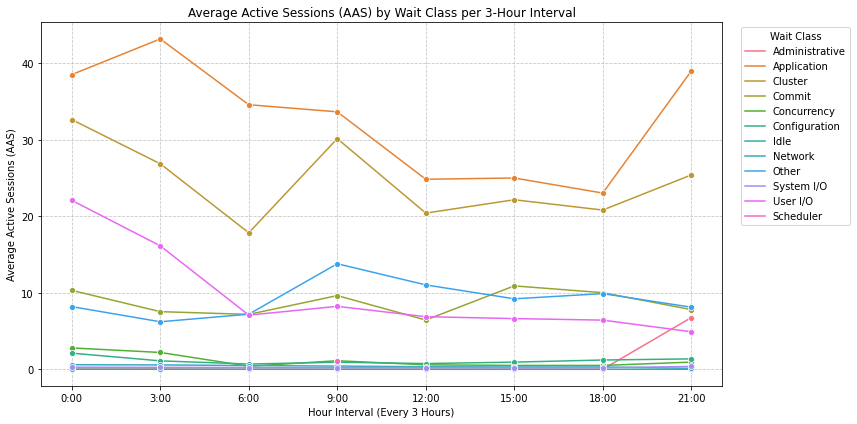

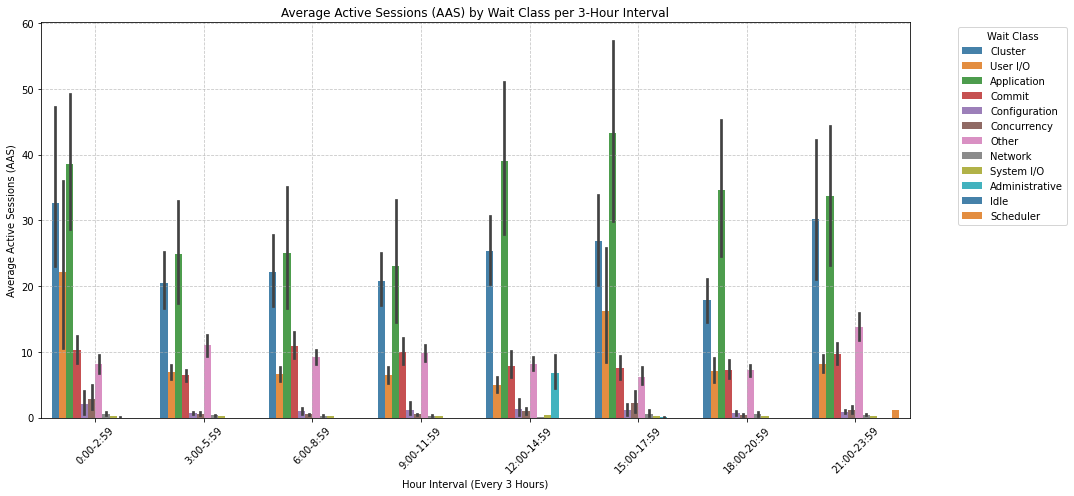

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract date and hour from timestamp
df['date'] = df['sample_time'].dt.date
df['hour'] = df['sample_time'].dt.hour

# 2. Create 3-hour interval column
df['hour_interval'] = (df['hour'] // 3) * 3  # Groups hours into intervals like 0-2, 3-5, etc.

# 3. Normalize AAS Calculation for Accurate Results
df['aas'] = df['session_count'] / 360  # 360 samples per hour if sampled every 10 seconds

# 4. Aggregate AAS by 3-Hour Interval and Wait Class
interval_wait_totals = df.groupby(['date','hour_interval', 'wait_class']).agg({
    'aas': 'sum',  # Average AAS per 3-hour interval per wait class
    'instance_number': 'nunique'  # Number of unique instances
}).reset_index()

# 5. Line Plot: AAS by Wait Class per 3-Hour Interval
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=interval_wait_totals, 
    x='hour_interval', 
    y='aas', 
    hue='wait_class', 
    marker='o',
    ci=None
)
plt.title('Average Active Sessions (AAS) by Wait Class per 3-Hour Interval')
plt.xlabel('Hour Interval (Every 3 Hours)')
plt.ylabel('Average Active Sessions (AAS)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 24, 3), labels=[f"{i}:00" for i in range(0, 24, 3)])  # Show hour intervals
plt.legend(title='Wait Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Bar Plot: Average AAS by Wait Class Across 3-Hour Intervals
# 1. Ensure hour_interval is a string category for proper distribution
interval_wait_totals['hour_interval'] = interval_wait_totals['hour_interval'].astype(str)

# 2. Use a distinct color palette
palette = sns.color_palette('tab10', n_colors=interval_wait_totals['wait_class'].nunique())

# 3. Bar Plot: Average AAS by Wait Class Across 3-Hour Intervals
plt.figure(figsize=(15, 7))
sns.barplot(
    data=interval_wait_totals.sort_values(['hour_interval', 'aas'], ascending=[True, False]),
    x='hour_interval',
    y='aas',
    hue='wait_class',
    palette=palette,
    dodge=True,
    alpha=0.9  # Slight transparency for better visibility
)

# 4. Titles and Labels
plt.title('Average Active Sessions (AAS) by Wait Class per 3-Hour Interval')
plt.xlabel('Hour Interval (Every 3 Hours)')
plt.ylabel('Average Active Sessions (AAS)')

# 5. X-axis ticks
plt.xticks(
    ticks=range(len(interval_wait_totals['hour_interval'].unique())),
    labels=[f"{int(i)}:00-{int(i)+2}:59" for i in sorted(interval_wait_totals['hour_interval'].astype(int).unique())],
    rotation=45
)

# 6. Legend and Grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Wait Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



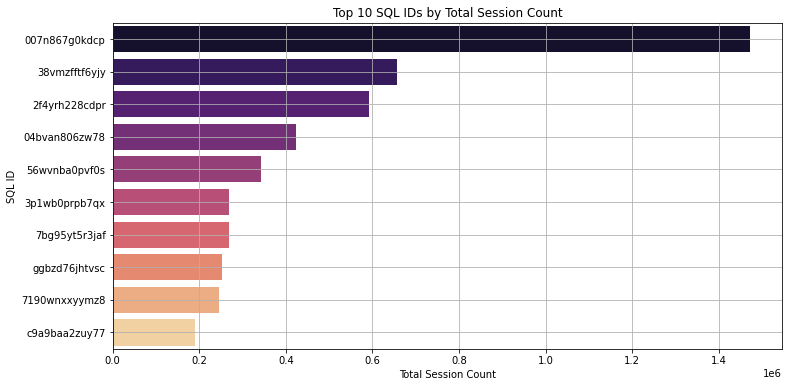

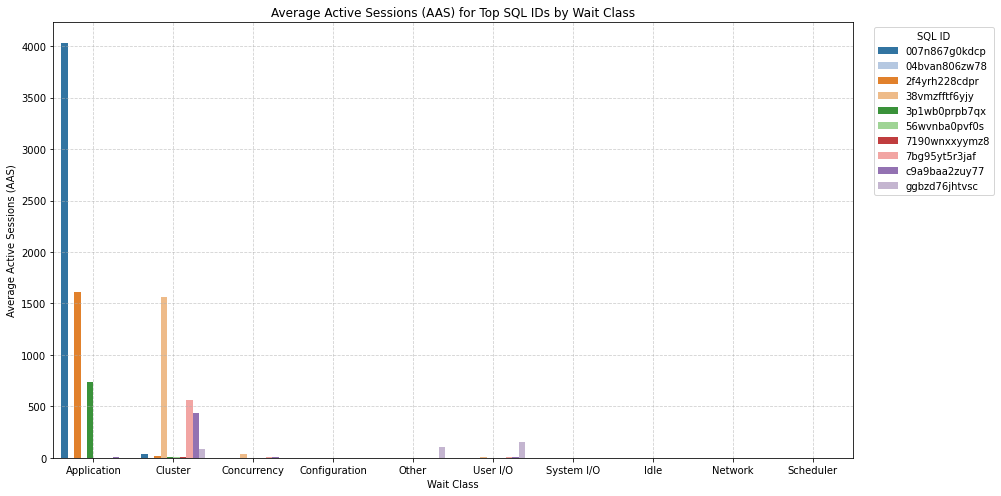

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract date and hour from timestamp
df['date'] = df['sample_time'].dt.date

df['aas'] = df['session_count'] / 360  # Normalize AAS for 10-second intervals

# 2. Aggregate session counts by SQL ID across all days
sql_id_totals = df.groupby('sql_id').agg({
    'aas': 'sum',               # Total AAS for each SQL ID
    'session_count': 'sum',     # Total session count for each SQL ID
    'instance_number': 'nunique'  # Number of unique instances running the SQL
}).reset_index()

# 3. Get Top 10 SQL IDs by Total Session Count
top_sql = sql_id_totals.nlargest(10, 'session_count')

# 4. Bar Plot for Top SQL IDs
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sql, x='session_count', y='sql_id', palette='magma')
plt.title('Top 10 SQL IDs by Total Session Count')
plt.xlabel('Total Session Count')
plt.ylabel('SQL ID')
plt.grid()
plt.show()

# 5. summary for reference
#print(top_sql)

# 4. Get Top 10 SQL IDs by Total Session Count (for performance)
top_sql_ids = sql_id_totals.nlargest(10, 'session_count')['sql_id']
filtered_df = df[df['sql_id'].isin(top_sql_ids)]

# 5. Aggregate AAS by SQL ID and Wait Class
sql_id_wait_class = filtered_df.groupby(['sql_id', 'wait_class']).agg({
    'aas': 'sum',  # Average AAS per SQL ID per wait class
    'instance_number': 'nunique'
}).reset_index()

# 6. Display summary
#print(sql_id_wait_class)

# 7. Plot: Average Active Sessions for Top SQL IDs by Wait Class
plt.figure(figsize=(14, 7))
sns.barplot(
    data=sql_id_wait_class,
    x='wait_class',
    y='aas',
    hue='sql_id',
    palette='tab20'
)
plt.title('Average Active Sessions (AAS) for Top SQL IDs by Wait Class')
plt.xlabel('Wait Class')
plt.ylabel('Average Active Sessions (AAS)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='SQL ID', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


